# Guide to using Kramers-Kronig method

Initial importing of libraries and modules:

In [2]:
# Preliminaries
from spectrum import *
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import numpy as np
current_path = Path.cwd()

Loading reference data set into a pandas dataframe using ``data_macro``:

In [80]:
pathMagneto = os.path.join(current_path, "Data", "Magneto-optics", "Facet_001")
inst_MO = Data_macro(auto = True, data_path = pathMagneto, units = "cm-1", data_head = "none", ref_head = "none", zero_field = True, flag_txt = False)
df_macro = inst_MO.auto()

# Select data and generate a sparser dataframe for improved processing time
df = df_macro.loc[:4000:2,5.0]

To carry out the Kramers-Kronig relation calculations, we use the method:<br> ``Treament.kramers_kronig()``<br>
``kramers_kronig(df, n, model, w_free, ptail, b)``
<br>
- ``df``: (pandas dataframe) The input dataframe of spectral data to be processed.<br><br>
- ``n``: (int) The number of data points to calculate for low energy extrapolation.<br><br>
- ``model``: (string) The model to be used to for low energy extrapolation.<br>("Hagen-Rubens", "Insulator", "Power law", "Metal", "Marginal Fermi liquid", "Gorter-Casimir two-fluid model", or "Superconducting")<br><br>
- ``w_free``: (float) The frequency of free-electron (plasma) behaviour.<br><br>
- ``ptail``: (int) The exponent for high-energy extrapolation in the interband region.<br><br>
- ``b``: (float) Additional parameter for models - the DC conductivity for "Hagen-Rubens", the zero-frequency reflectance for "Insulator", and the exponent for "Power law". 

In [87]:
proc_df = Treatment.kramers_kronig(df, n = 20, model = "Hagen-Rubens", w_free = 50000, ptail = 1, b = 2)
proc_df

c:\Users\jamie\OptDect\sharedmodule\dataAnalysis.py:942: RuntimeWarning: divide by zero encountered in true_divide
  phase = phase - (np.log(R[-1])-np.log(R))*np.log((w[-1]+w)/(w[-1]-w))/(2*pi) + w*(ptail/w[-1]+(4-ptail)/w_free)/pi + (ptail*(w/w[-1])**3) + (4-ptail)*(w/w_free)**3/(9*pi)
c:\Users\jamie\OptDect\sharedmodule\dataAnalysis.py:942: RuntimeWarning: invalid value encountered in multiply
  phase = phase - (np.log(R[-1])-np.log(R))*np.log((w[-1]+w)/(w[-1]-w))/(2*pi) + w*(ptail/w[-1]+(4-ptail)/w_free)/pi + (ptail*(w/w[-1])**3) + (4-ptail)*(w/w_free)**3/(9*pi)


,er,ei,R,sr,phase
0.348743,5268.801551,12811.934305,0.972161,74.467860,0.009459
0.638708,2731.675658,6900.249080,0.962326,73.454023,0.013051
1.168957,1084.074243,3605.406623,0.949033,70.242763,0.019452
2.136716,470.709735,1890.513890,0.931092,67.324853,0.027909
3.896692,231.501508,1000.752887,0.906945,64.993760,0.038855
...,...,...,...,...,...
3990.445779,-1.531668,0.006965,0.995564,0.463246,1.359209
3992.374462,-1.526294,0.006284,0.995982,0.418106,1.360928
3994.303146,-1.520773,0.005783,0.996286,0.385014,1.362701
3996.231829,-1.515249,0.005710,0.996318,0.380336,1.364482


<AxesSubplot:>

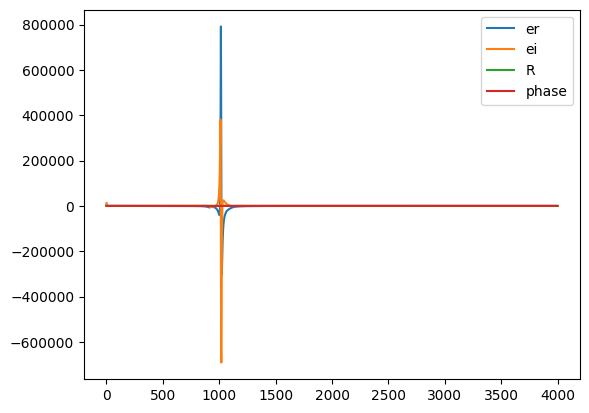

In [88]:
proc_df[["er","ei","R","phase"]].plot()

# Low energy extrapolation models

The equations below describe how the low-energy reflectivity $R$ is modelled as a function of the frequency $\omega$.

### Hagen-Rubens

$R(\omega) = 1 - \sqrt{2\omega / 15\sigma}$,

where the conductivity $\sigma$ is given by the user.

### Insulator

$R(\omega) = R_0 + a \omega^2$,

where the zero-frequency reflectivity $R_0$ is given by the user and the coefficient $a$ is calculated from the first three datapoints.

### Power law

$R(\omega) = 1 - a \omega^{apow}$,

where the exponent $apow$ is given by the user and the coefficient $a$ is calculated from the first datapoint.

### Metal

$R(\omega) = 1 - a \sqrt{\omega}$,

where the coefficient $a$ is calculated from the first datapoint.

### Marginal Fermi liquid

$R(\omega) = 1 - a \omega$,

where the coefficient $a$ is calculated from the first datapoint.

### Gorter-Casimir two-fluid model

$R(\omega) = 1 - a \omega^2$,

where the coefficient $a$ is calculated from the first datapoint.

### Superconducting

$R(\omega) = 1 - a \omega^4$,

where the coefficient $a$ is calculated from the first datapoint.


# Kramers-Kronig widget
<br>Assumes input cropped dataframe is named ``df``


In [102]:
# RUN ME
from IPython.display import display, clear_output
import ipywidgets as widgets

class InteractiveUI:
    def __init__(self, df):
        self.options = ["Hagen-Rubens", "Insulator", "Power law", "Metal", "Marginal Fermi Liquid", "Gorter-Casimir two-fluid model", "Superconducting"]
        self.dropdown = widgets.Dropdown(options=self.options, description="Select model:")

        self.n_input = widgets.Text(description="Number of points to calculate:",style={'description_width':'initial'})
        self.wfree_input = widgets.Text(description='Free-electron frequency:',style={'description_width':'initial'})
        self.ptail_input = widgets.Text(description='Exponent of interband region:',style={'description_width':'initial'})

        self.text_input = widgets.Text()
        self.text_input.layout.display = 'none'

        self.button = widgets.Button(description="Run KK")
        self.button.on_click(self.button_click)

        self.dropdown.observe(self.dropdown_event_handler, names='value')
        self.update_ui()

    def dropdown_event_handler(self, change):
        self.update_ui()

    def hide_widgets(self, *widgets):
        for widget in widgets:
            widget.layout.display = 'none'

    def display_widgets(self, *widgets):
        for widget in widgets:
            widget.layout.display = 'block'

    def button_click(self, button):
        model = self.dropdown.value
        try: 
            n = int(self.n_input.value)
            ptail = int(self.ptail_input.value)
        except ValueError:
            print("Error: values entered for n and ptail must be integers")

        try: 
            wfree = float(self.wfree_input.value)
        except ValueError:
            print("Error: value entered for wfree must be a float")
    
        if model in ["Hagen-Rubens", "Insulator", "Power law"]:
            try:
                float(self.text_input.value)
            except ValueError:
                print ("Error: value entered must be a float")
            b = float(self.text_input.value)
        else:
            b = None

        print("Processing...")
        proc_df = Treatment.kramers_kronig(df, model=model, n=n, w_free=wfree, ptail=ptail, b=b)
        print(proc_df)

    def update_ui(self):
        clear_output(wait=True)
        selected_option = self.dropdown.value
        if selected_option in ["Hagen-Rubens", "Insulator", "Power law"]:
            self.display_widgets(self.text_input, self.button)
            if selected_option == "Hagen-Rubens":
                self.text_input.description = "Conductivity:"
            elif selected_option == "Insulator":
                self.text_input.description = "Constant:"
            elif selected_option == "Power law":
                self.text_input.description = "Exponent:"
            self.text_input.layout.visibility = 'visible'
        else:
            self.display_widgets(self.text_input, self.button)
            self.hide_widgets(self.text_input)

        display(self.n_input, self.wfree_input, self.ptail_input, self.dropdown, self.text_input, self.button)

# Create an instance of the InteractiveUI class
ui = InteractiveUI(df)


Text(value='', description='Number of points to calculate:', style=TextStyle(description_width='initial'))

Text(value='', description='Free-electron frequency:', style=TextStyle(description_width='initial'))

Text(value='', description='Exponent of interband region:', style=TextStyle(description_width='initial'))

Dropdown(description='Select model:', options=('Hagen-Rubens', 'Insulator', 'Power law', 'Metal', 'Marginal Fe…

Text(value='', description='Conductivity:', layout=Layout(display='block', visibility='visible'))

Button(description='Run KK', layout=Layout(display='block'), style=ButtonStyle())

Processing...
                      er            ei         R         sr     phase
0.348743     5268.801551  12811.934305  0.972161  74.467860  0.009459
0.638708     2731.675658   6900.249080  0.962326  73.454023  0.013051
1.168957     1084.074243   3605.406623  0.949033  70.242763  0.019452
2.136716      470.709735   1890.513890  0.931092  67.324853  0.027909
3.896692      231.501508   1000.752887  0.906945  64.993760  0.038855
...                  ...           ...       ...        ...       ...
3990.445779    -1.531668      0.006965  0.995564   0.463246  1.359209
3992.374462    -1.526294      0.006284  0.995982   0.418106  1.360928
3994.303146    -1.520773      0.005783  0.996286   0.385014  1.362701
3996.231829    -1.515249      0.005710  0.996318   0.380336  1.364482
3998.160512    -1.515247      0.006237  0.995979   0.415611  1.364482

[1913 rows x 5 columns]


c:\Users\jamie\OptDect\sharedmodule\dataAnalysis.py:942: RuntimeWarning: divide by zero encountered in true_divide
  phase = phase - (np.log(R[-1])-np.log(R))*np.log((w[-1]+w)/(w[-1]-w))/(2*pi) + w*(ptail/w[-1]+(4-ptail)/w_free)/pi + (ptail*(w/w[-1])**3) + (4-ptail)*(w/w_free)**3/(9*pi)
c:\Users\jamie\OptDect\sharedmodule\dataAnalysis.py:942: RuntimeWarning: invalid value encountered in multiply
  phase = phase - (np.log(R[-1])-np.log(R))*np.log((w[-1]+w)/(w[-1]-w))/(2*pi) + w*(ptail/w[-1]+(4-ptail)/w_free)/pi + (ptail*(w/w[-1])**3) + (4-ptail)*(w/w_free)**3/(9*pi)
